In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from datetime import date, datetime, timedelta

In [ ]:
df = pd.read_csv('member_sample.csv', index_col = 0)

In [ ]:
df.head()

In [ ]:
df.City.value_counts().nlargest(15)

### Build a Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [ ]:
pipe = Pipeline([('sscaler', StandardScaler()), ('ridge', Ridge())])

### Example of Creating a Class for Transformations

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class TripleATransfrom(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.where(X == 'Y', 1, 0)

In [ ]:
transformer = TripleATransfrom()

In [ ]:
transformer.fit(df, df['Total Cost'])

In [ ]:
df['FSV CMSI Flag'] = transformer.transform(df['FSV CMSI Flag'])

In [ ]:
df['FSV CMSI Flag'].value_counts()

In [ ]:
df['SC Vehicle Manufacturer Name'].value_counts().nlargest(15)


### Focus on Costs

In [ ]:
#Find columns that contains 'String' value
def print_cols(df, string):
    cols = [i for i in df.columns if string in i]
    return cols

In [ ]:
cost_cols = print_cols(df, 'Cost')
cost_cols

In [56]:
cost_df = df[['Individual Key', 'Household Key', 'Call Status Recv Date', 'ERS Member Cost Year 1','ERS Member Cost Year 2','ERS Member Cost Year 3',
 'Basic Cost', 'Plus Cost','Premier Cost','Total Cost','Dispatch Code1 Description']]

In [57]:
cost_df.head()

,Individual Key,Household Key,Call Status Recv Date,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,Basic Cost,Plus Cost,Premier Cost,Total Cost,Dispatch Code1 Description
0,10000003.0,10462590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52211550.0,4500791.0,2017-04-13 10:05:17,0.0,0.0,65.0,32.5,0.0,0.0,32.5,Engine Overheat
2,52211550.0,4500791.0,2016-07-26 11:27:57,0.0,0.0,65.0,30.0,0.0,0.0,30.0,Member Requests Battery Service
3,52211550.0,4500791.0,2017-02-13 11:17:47,0.0,0.0,65.0,32.5,0.0,0.0,32.5,Member Requests Battery Service
4,52211550.0,4500791.0,2015-01-29 14:34:29,0.0,0.0,65.0,30.0,0.0,0.0,30.0,No Crank - Jump Start


In [ ]:
cost_df[cost_df['Individual Key'] == 52211550.0]

In [ ]:
ex_member = cost_df[cost_df['Individual Key'] == 52211550.0]

In [ ]:
ex_member['Call Status Recv Date'] = pd.to_datetime(ex_member['Call Status Recv Date'])

In [ ]:
ex_member['year'] = ex_member['Call Status Recv Date'].dt.year

In [ ]:
ex_member

In [ ]:
ex_member.groupby('year')[['ERS Member Cost Year 3', 'Total Cost']].agg(
    {'ERS Member Cost Year 3':['max'], 'Total Cost':['sum']})

### Aggregating

In [ ]:
individual_cost = cost_df.groupby('Individual Key')['Total Cost'].sum()

In [ ]:
individual_cost.head()

In [ ]:
a = cost_df.groupby(['Household Key','Individual Key'])['Total Cost'].sum()

In [ ]:
a.reset_index(level = [0,1])[:10]

### Motorcycles have much higher AAA incident Cost

In [ ]:
df.groupby('SC Vehicle Manufacturer Name')['Total Cost'].mean().nlargest(25).plot(kind = 'bar')
plt.xticks(rotation = 90)


In [ ]:
df.groupby('SC Vehicle Model Name')['Total Cost'].mean().nlargest(20).plot(kind = 'bar')
plt.xticks(rotation = 60)

In [ ]:
df.groupby('Dispatch Code1 Description')['Total Cost'].sum().nlargest(20).plot(kind = 'bar')
plt.xticks(rotation = 90)

In [ ]:
df['Birth Date MMDDYYYY'].head()

In [ ]:
df['DOB'] = pd.to_datetime(df['Birth Date MMDDYYYY'])

In [ ]:
import datetime

In [ ]:
now = datetime.datetime.now()

In [ ]:
df['age'] = now.year - df['DOB'].dt.year

In [37]:
df.age.value_counts().nlargest(30)

73.0    665
74.0    569
71.0    566
72.0    518
70.0    481
39.0    480
78.0    471
76.0    464
69.0    457
68.0    456
75.0    454
77.0    396
79.0    394
67.0    387
80.0    374
83.0    354
87.0    350
85.0    342
92.0    337
66.0    335
84.0    334
89.0    333
81.0    315
91.0    309
88.0    309
90.0    306
82.0    302
93.0    283
94.0    276
86.0    269
Name: age, dtype: int64

In [38]:
#Fill missing age values with mean = 69.4
df.age.fillna(df.age.mean(), inplace = True)

In [39]:
df.age.isna().sum()

0

In [40]:
df.age.describe()

count    21344.000000
mean        69.462861
std         17.423438
min         18.000000
25%         64.000000
50%         70.000000
75%         81.000000
max        113.000000
Name: age, dtype: float64

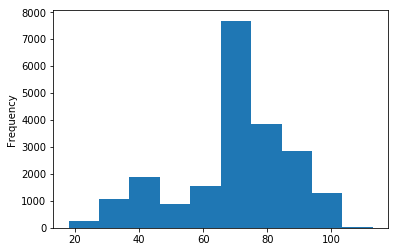

In [41]:
df.age.plot(kind = 'hist')

### Do Feature Engineering and Build Regressor

In [58]:
cost_df = cost_df.loc[:, ['Household Key', 'Total Cost', 'Dispatch Code1 Description']]

In [59]:
cost_dummied = pd.get_dummies(cost_df, columns = ['Dispatch Code1 Description'], drop_first = True)

In [60]:
cost_dummied.head()

,Household Key,Total Cost,Dispatch Code1 Description_Brake System Failure,Dispatch Code1 Description_Car Alarm Issue,Dispatch Code1 Description_Collision/Police Tow,Dispatch Code1 Description_Convenience/Member Concern Tow,Dispatch Code1 Description_Crank No Start,Dispatch Code1 Description_EV Out Of Charge Station Range,Dispatch Code1 Description_Engine Overheat,Dispatch Code1 Description_Engine Runs Poorly,...,Dispatch Code1 Description_Other Service (describe),Dispatch Code1 Description_Out Of Gasoline,Dispatch Code1 Description_Parking Brake Won't Release,Dispatch Code1 Description_Taxi/Shuttle Service,Dispatch Code1 Description_Tire Issue Requires Tow To Shop,Dispatch Code1 Description_Transmission/Clutch Failure,Dispatch Code1 Description_Undercar Component Dragging,Dispatch Code1 Description_Vehicle Fire,Dispatch Code1 Description_Vehicle Mis-Fueled,Dispatch Code1 Description_Windshield Damage
0,10462590.0,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4500791.0,32.5,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4500791.0,30.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4500791.0,32.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4500791.0,30.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
cost_dummied.groupby('Household Key').sum().head()

,Total Cost,Dispatch Code1 Description_Brake System Failure,Dispatch Code1 Description_Car Alarm Issue,Dispatch Code1 Description_Collision/Police Tow,Dispatch Code1 Description_Convenience/Member Concern Tow,Dispatch Code1 Description_Crank No Start,Dispatch Code1 Description_EV Out Of Charge Station Range,Dispatch Code1 Description_Engine Overheat,Dispatch Code1 Description_Engine Runs Poorly,Dispatch Code1 Description_Engine Stalled While Driving,...,Dispatch Code1 Description_Other Service (describe),Dispatch Code1 Description_Out Of Gasoline,Dispatch Code1 Description_Parking Brake Won't Release,Dispatch Code1 Description_Taxi/Shuttle Service,Dispatch Code1 Description_Tire Issue Requires Tow To Shop,Dispatch Code1 Description_Transmission/Clutch Failure,Dispatch Code1 Description_Undercar Component Dragging,Dispatch Code1 Description_Vehicle Fire,Dispatch Code1 Description_Vehicle Mis-Fueled,Dispatch Code1 Description_Windshield Damage
Household Key,,,,,,,,,,,,,,,,,,,,,
875.0,1063.20,0,0,0,1,0,0,0,2,0,...,0,0,0,0,0,3,0,0,0,0
969.0,226.10,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3338.0,0.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8718.0,0.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11524.0,294.25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [89]:
reg_df = cost_dummied.groupby('Household Key').sum()

In [90]:
from sklearn.linear_model import LinearRegression

In [91]:
lr = LinearRegression()

In [92]:
X = reg_df.drop('Total Cost', axis = 1)

In [93]:
y = reg_df['Total Cost']

In [94]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [95]:
results_df = pd.DataFrame({'features': X.columns, 'coefs': lr.coef_})

In [96]:
results_df.sort_values('coefs',ascending = False)

,features,coefs
45,Dispatch Code1 Description_Taxi/Shuttle Service,104.945019
42,Dispatch Code1 Description_Other Service (desc...,99.412992
24,Dispatch Code1 Description_Leaking Fluids,92.498207
14,Dispatch Code1 Description_Home Lockout,88.806848
15,Dispatch Code1 Description_Hood/Door Won't Clo...,79.094361
6,Dispatch Code1 Description_Engine Overheat,78.201502
41,Dispatch Code1 Description_Other Runs Won't Mo...,74.815207
0,Dispatch Code1 Description_Brake System Failure,67.541332
47,Dispatch Code1 Description_Transmission/Clutch...,62.291478
22,Dispatch Code1 Description_Known Alternator Pr...,61.662554


### Decision Treee

In [97]:
from sklearn.tree import DecisionTreeRegressor

In [109]:
tree = DecisionTreeRegressor(max_depth =4)

In [110]:
tree.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [111]:
tree.score(X, y)

0.7983645271243857

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [106]:
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.5336547755522054

In [112]:
tree_df = pd.DataFrame({'features': X.columns, 'coefs': tree.feature_importances_})

In [113]:
tree_df.sort_values('coefs',ascending = False)

,features,coefs
41,Dispatch Code1 Description_Other Runs Won't Mo...,0.656954
29,Dispatch Code1 Description_Member Requests Bat...,0.159745
12,Dispatch Code1 Description_Flat Tire w/spare,0.068302
39,Dispatch Code1 Description_Other Required Tow ...,0.065423
3,Dispatch Code1 Description_Convenience/Member ...,0.049575
30,Dispatch Code1 Description_Member Requests Tow,0.000000
31,Dispatch Code1 Description_Multiple Flat Tires,0.000000
32,Dispatch Code1 Description_Need Air In Tire,0.000000
33,Dispatch Code1 Description_No Crank - Bat Svc ...,0.000000
34,Dispatch Code1 Description_No Crank - Bat Svc ...,0.000000


In [ ]:
b